### W tym notebooku znajduje się:
- wytrenowany model z ostatecznymi hiperparametrami i operacjami,
- podział danych,
- predykcja,
- wykres wartości przewidywanej od oczekiwanej,
- zapis modelu do pliku .pkl.

Import potrzebnych bibliotek:

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

import pickle

Wczytanie pliku z danymi:

In [14]:
df = pd.read_csv("postings_for_model.csv")

Usunięcie outlierów:

In [15]:
df = df[(df['normalized_salary_minmax'] > 0.08) & (df['normalized_salary_minmax'] < 0.92)]

Podział na target - y i features - X.

In [16]:
y = df['normalized_salary_minmax']
X = df.drop(columns=['normalized_salary_minmax'])

In [17]:
with open("xgb_columns.pkl", "wb") as f:
    pickle.dump(list(X.columns), f)

Podział danych na zbiór treningowy i walidacyjny:

In [18]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

Trening modelu:

In [19]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=10,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=0.7,
    random_state=42,
    verbosity=0
)

model.fit(train_X, train_y)
y_pred = model.predict(val_X)

Metryki:

In [20]:
mae = mean_absolute_error(val_y, y_pred)
r2 = r2_score(val_y, y_pred)
print(f"MAE: {mae:.4f}, R²: {r2:.4f}")

MAE: 0.1006, R²: 0.5071


Wykres przewiydwanego wynagrodzenia od rzeczywistego wynagrodzenia:

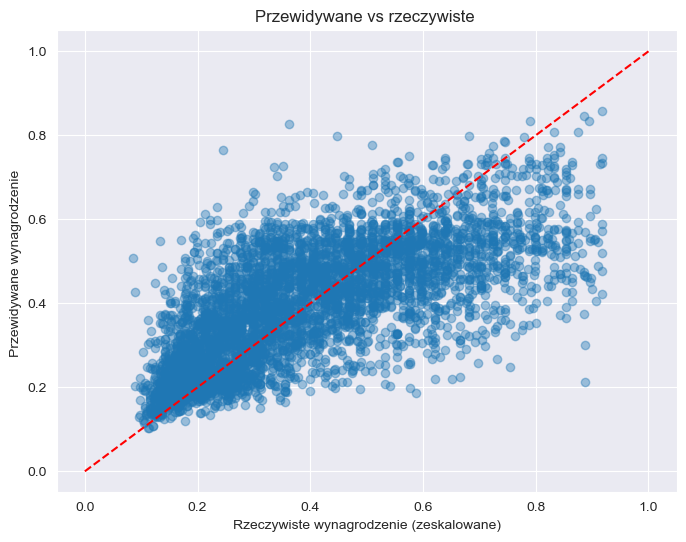

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(val_y, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Rzeczywiste wynagrodzenie (zeskalowane)")
plt.ylabel("Przewidywane wynagrodzenie ")
plt.title("Przewidywane vs rzeczywiste ")
plt.grid(True)
plt.show()

### Przeliczenie MAE na USD:

Potrzebny jest mi inny plik csv, w którym nie mamy przeskalowanej wartości normalized_salary, z niego pobieram wartość minimalną i maksymalną dla normalized_salary,
dzięki czemu mogę przeliczyć wskaźnik MAE, na rzeczywistą kwotę:

In [22]:
postings = pd.read_csv("finished_postings.csv")

In [23]:
min_salary = postings['normalized_salary'].min()
max_salary = postings['normalized_salary'].max()

In [24]:
mae_normalized = 0.1006  # wynik modelu
mae_usd = mae_normalized * (max_salary - min_salary)
print(f"MAE w USD: {mae_usd:.2f}")

MAE w USD: 23590.70


### Zapis modelu do pliku .pkl:

In [25]:
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model zapisany do pliku: xgb_model.pkl")

Model zapisany do pliku: xgb_model.pkl
